In [1]:
import copy
import pickle
import importlib
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyplot_themes as themes
themes.theme_minimal()

In [2]:
# Load the dataset
from data_loader import get_component_events, read_dataset, preprocess

all_component_events = get_component_events()
voltage, current, y = read_dataset(all_component_events, start_offset=0, duration=4)
voltage, current = preprocess(voltage, current, 50)

100.0%

In [3]:
# Calculate the features
import feature_selection
from features.helpers import get_all_features

features = get_all_features(voltage, current)
n_features = feature_selection.normalize_features(features)

line_del = ''.join(itertools.repeat('\r', 50))

In [4]:
# Helper function for the thesis :)
def df_to_latex_table(df, remove_index=True, hlines=False, round=3):
    for column in df.columns:
        if df.dtypes[column] == np.float:
            df = copy.deepcopy(df)
            df[column] = df[column].round(round)
    end_delim = ' \\\\\n' if not hlines else ' \\\\ \\hline\n'
    start_idx = 1 if remove_index else 0
    columns = df.columns if remove_index else np.hstack((['index'], df.columns))
    orientation = 'c' * len(columns)

    s = "\\begin{tabular}{" + orientation + "}\n"
    s += '\t' + ' & '.join(columns) + end_delim
    for line in df.itertuples():
        s+= '\t' + ' & '.join(map(str, line[start_idx:])) + end_delim
    return s + "\\end{tabular}"

## Feature overview

In [5]:
feature_selection.print_feature_info(features)

Total of 56 features:

                                                        name  dimension
                                                Active power          1
                                             Peak-mean ratio          1
                                            Max inrush ratio          1
                  Wavelet transform dominant scale (voltage)          1
                                         Waveform distortion          1
                                     Periods to steady state          1
                                                2nd harmonic          1
                               Transient steady states ratio          1
         High frequency spectral centroid (zero-type filter)          1
         High frequency spectral flatness (zero-type filter)          1
                                               Max-min ratio          1
             High frequency spectral mean (zero-type filter)          1
       High frequency spectral flatness (

## Individual features

In [6]:
from features.helpers import feature_evaluation, get_feature_type

classifiers = ['knn', 'svc', 'ridge', 'decision_tree', 'adaboost']
df = pd.DataFrame(columns=['dimension'] + classifiers)

for feature in n_features:
    df.loc[feature, 'dimension'] = n_features[feature].shape[1]
df['dimension'] = df['dimension'].astype(np.int)

for classifier in classifiers:
    evaluation = feature_selection.get_evaluation(classifier)
    for feature in n_features:
        print(line_del, classifier, feature, end='')
        score, _ = evaluation(n_features[feature], y)
        df.loc[feature, classifier] = score
    df[classifier] = df[classifier].astype(np.float)
print(line_del, end='')

# Evaluating all features, so we're pickling the results
with open('notebooks/single_features.pkl', 'wb') as f:
    pickle.dump(df, f)

In [7]:
# Use the pickled results
with open('notebooks/single_features.pkl', 'rb') as f:
    df = pickle.load(f)

df = df.rename_axis('feature')
df['feature_type'] = df.index.map(get_feature_type)
df = df[['feature_type', 'dimension', 'ridge', 'svc', 'knn', 'decision_tree', 'adaboost']]
df = df.sort_values(by=['feature_type', 'dimension', 'feature'])

# print(df_to_latex_table(df, remove_index=False, hlines=True))
df

,feature_type,dimension,ridge,svc,knn,decision_tree,adaboost
feature,,,,,,,
Active power,electrical,1,0.572107,0.846105,0.820959,0.844327,0.802669
Admittance (mean),electrical,1,0.580972,0.844747,0.836640,0.837853,0.778590
Admittance (median),electrical,1,0.446397,0.829052,0.830529,0.832705,0.793758
Apparent power,electrical,1,0.577805,0.834456,0.826020,0.857678,0.806984
Crest factor,electrical,1,0.478233,0.724573,0.730566,0.741468,0.730070
Form factor,electrical,1,0.478753,0.828819,0.808104,0.794502,0.791427
Inrush current ratio,electrical,1,0.280217,0.918628,0.912744,0.921396,0.771805
Log attack time,electrical,1,0.442299,0.444919,0.600425,0.566031,0.447342
Max inrush ratio,electrical,1,0.433190,0.768109,0.768987,0.766368,0.750938


In [8]:
df_filter = (df['ridge'] > 0.8) | (df['knn'] > 0.8) | (df['svc'] > 0.8) | (df['decision_tree'] > 0.8) | (df['adaboost'] > 0.8)
print("Percentage > 0.8:", len(df[df_filter]) / len(df))

df_filter = (df['dimension'] == 1) & ((df['ridge'] > 0.8) | (df['knn'] > 0.8) | (df['svc'] > 0.8) | (df['decision_tree'] > 0.8) | (df['adaboost'] > 0.8))
print("Percentage one-dim > 0.8:", len(df[df_filter]) / len(df[df.dimension == 1]))

Percentage > 0.8: 0.5535714285714286
Percentage one-dim > 0.8: 0.5


In [41]:
classifiers_average = pd.DataFrame(columns=['average_score'])
for classifier in classifiers:
    classifiers_average.loc[classifier, 'average_score'] = np.mean(df[classifier])
classifiers_average['average_score'] = classifiers_average['average_score'].astype(np.float)

classifiers_average

,average_score
knn,0.752144
svc,0.751008
ridge,0.494168
decision_tree,0.752560
adaboost,0.716549


In [9]:
best_one_dim = pd.DataFrame(columns=['feature', 'score'])
best_one_dim['score'] = best_one_dim.astype(np.float)
for classifier in classifiers:
    best_feature = df[df.dimension == 1][classifiers].idxmax()[classifier]
    best_one_dim.loc[classifier, 'feature'] = best_feature
    best_one_dim.loc[classifier, 'score'] = df.loc[best_feature, classifier]

# print(df_to_latex_table(best_one_dim, remove_index=False))
best_one_dim

,feature,score
knn,Inrush current ratio,0.912744
svc,Inrush current ratio,0.918628
ridge,2nd harmonic,0.607174
decision_tree,Inrush current ratio,0.921396
adaboost,Total harmonic distortion,0.874469


In [10]:
best_all_dim = pd.DataFrame(columns=['feature', 'score', 'dimension'])
for classifier in classifiers:
    best_feature = df[classifiers].idxmax()[classifier]
    best_all_dim.loc[classifier, 'feature'] = best_feature
    best_all_dim.loc[classifier, 'score'] = df.loc[best_feature, classifier]
    best_all_dim.loc[classifier, 'dimension'] = df.loc[best_feature, 'dimension']
best_all_dim['score'] = best_all_dim['score'].astype(np.float)
best_all_dim['dimension'] = best_all_dim['dimension'].astype(np.int)

# print(df_to_latex_table(best_all_dim, remove_index=False))
best_all_dim

,feature,score,dimension
knn,Inrush current ratio,0.912744,1
svc,Wavelet transform energy over time (current),0.929669,5
ridge,Harmonics (first 20),0.894993,20
decision_tree,Inrush current ratio,0.921396,1
adaboost,Harmonics energy distribution,0.908452,20


## Combinations of two features

In [11]:
df = feature_selection.feature_combinations(n_features, y, 2)

# Evaluating all combinations takes quite some time, so we're pickling the results
with open('notebooks/two_combs.pkl', 'wb') as f:
    pickle.dump(df, f)

Calculations finished in 2:51:12


In [12]:
# Use the pickled results
with open('notebooks/two_combs.pkl', 'rb') as f:
    df = pickle.load(f)
df

,model,feature_combination,dimension,score
1748,svc,"(Phase shift, Wavelet transform energy over ti...",6,0.935562
1643,svc,"(Reactive power, Wavelet transform energy over...",6,0.935082
1733,svc,"(Phase shift, Current RMS)",6,0.934799
2128,svc,"(Crest factor, Wavelet transform energy over t...",6,0.934459
2884,svc,"(Current RMS, Wavelet transform energy over ti...",10,0.934192
...,...,...,...,...
4082,ridge,"(Inrush current ratio, Wavelet transform detai...",3,0.280060
4579,ridge,(Wavelet transform details coefficients (max l...,4,0.279182
4577,ridge,(Wavelet transform details coefficients (max l...,3,0.277166
4600,ridge,"(Wavelet transform dominant scale (current), W...",3,0.276759


In [13]:
best = df.loc[df.groupby('model').apply(lambda x: x.score.idxmax())]
# print(df_to_latex_table(best))
best

,model,feature_combination,dimension,score
6484,adaboost,"(Harmonics energy distribution, Admittance (me...",21,0.918578
5599,decision_tree,"(Inrush current ratio, Positive-negative half ...",2,0.933260
1038,knn,"(Positive-negative half cycle ratio, Wavelet t...",6,0.924557
3337,ridge,"(VI Trajectory, Wavelet transform (all levels)...",52,0.923115
1748,svc,"(Phase shift, Wavelet transform energy over ti...",6,0.935562


In [14]:
best = df[df.dimension == 2]
best = best.loc[best.groupby('model').apply(lambda x: x.score.idxmax())]
# print(df_to_latex_table(best))
best

,model,feature_combination,dimension,score
6774,adaboost,"(Total harmonic distortion, 2nd harmonic)",2,0.905937
5599,decision_tree,"(Inrush current ratio, Positive-negative half ...",2,0.933260
10,knn,"(Active power, Crest factor)",2,0.923165
4376,ridge,"(2nd harmonic, High frequency spectral flatnes...",2,0.838717
1564,svc,"(Active power, Peak-mean ratio)",2,0.931211


## Stepwise regression

### Combinations of two features

In [15]:
classifiers = ['knn', 'svc', 'ridge', 'decision_tree', 'adaboost']
df = pd.DataFrame(columns=['features', 'score', 'estimator'], index=classifiers)

for classifier in classifiers:
    best = feature_selection.simple_stepwise_regression(
        n_features, y, classifier, max=2
    )
    df.loc[classifier, 'features'] = best.features
    df.loc[classifier, ['score', 'estimator']] = (best.score, best.estimator)

# Doing all stepwise regression takes quite some time, so we're pickling the results
with open('notebooks/stepwise_regression_two.pkl', 'wb') as f:
    pickle.dump(df, f)

    change_type                                             change     score
19  addition of                               Inrush current ratio  0.912744
7   addition of       Wavelet transform energy over time (current)  0.911269
26  addition of                                        Current RMS  0.907468
52  addition of                               Harmonics (first 20)  0.895390
13  addition of                      Harmonics energy distribution  0.892287
6   addition of                                Mean variance ratio  0.880025
34  addition of                      Transient steady states ratio  0.879045
14  addition of                               Admittance over time  0.873101
46  addition of                                  Current over time  0.871793
15  addition of                          Total harmonic distortion  0.871432
0   addition of                                      VI Trajectory  0.858582
24  addition of                             Waveform approximation  0.857478

In [16]:
# Use the pickled results
with open('notebooks/stepwise_regression_two.pkl', 'rb') as f:
    df = pickle.load(f)
df

,features,score,estimator
knn,"[Inrush current ratio, Odd even harmonics ratio]",0.921318,"KNeighborsClassifier(algorithm='auto', leaf_si..."
svc,"[Wavelet transform energy over time (current),...",0.935562,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
ridge,"[Harmonics (first 20), Harmonics energy distri...",0.914804,"RidgeClassifier(alpha=0.01, class_weight=None,..."
decision_tree,"[Inrush current ratio, Positive-negative half ...",0.93326,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
adaboost,"[Harmonics energy distribution, Resistance (me...",0.918578,"AdaBoostClassifier(algorithm='SAMME.R', base_e..."


In [17]:
df['dimension'] = df.features.map(lambda l: sum(features[f].shape[1] for f in l))
df = df[['features', 'dimension', 'score']]
# print(df_to_latex_table(df, remove_index=False))
df

,features,dimension,score
knn,"[Inrush current ratio, Odd even harmonics ratio]",2,0.921318
svc,"[Wavelet transform energy over time (current),...",6,0.935562
ridge,"[Harmonics (first 20), Harmonics energy distri...",40,0.914804
decision_tree,"[Inrush current ratio, Positive-negative half ...",2,0.93326
adaboost,"[Harmonics energy distribution, Resistance (me...",21,0.918578


### Combinations of two one-dimensional features

In [18]:
classifiers = ['knn', 'svc', 'ridge', 'decision_tree', 'adaboost']
df = pd.DataFrame(columns=['features', 'score', 'estimator'], index=classifiers)

for classifier in classifiers:
    best = feature_selection.simple_stepwise_regression(
        n_features, y, classifier, max=2, one_dim=True
    )
    df.loc[classifier, 'features'] = best.features
    df.loc[classifier, ['score', 'estimator']] = (best.score, best.estimator)

# Doing all stepwise regression takes quite some time, so we're pickling the results
with open('notebooks/stepwise_regression_two_one_dim.pkl', 'wb') as f:
    pickle.dump(df, f)

    change_type                                             change     score
13  addition of                               Inrush current ratio  0.912744
4   addition of                                Mean variance ratio  0.880025
24  addition of                      Transient steady states ratio  0.879045
9   addition of                          Total harmonic distortion  0.871432
31  addition of                                     Reactive power  0.846162
38  addition of     Wavelet transform (1st level) energy (current)  0.841835
27  addition of                                  Temporal centroid  0.841276
36  addition of                                       2nd harmonic  0.839681
23  addition of                                  Admittance (mean)  0.836640
11  addition of                                  Resistance (mean)  0.835795
35  addition of                                Admittance (median)  0.830529
16  addition of                           Odd even harmonics ratio  0.826122

In [19]:
# Use the pickled results
with open('notebooks/stepwise_regression_two_one_dim.pkl', 'rb') as f:
    df = pickle.load(f)
df

,features,score,estimator
knn,"[Inrush current ratio, Odd even harmonics ratio]",0.921318,"KNeighborsClassifier(algorithm='auto', leaf_si..."
svc,"[Inrush current ratio, Resistance (mean)]",0.928108,"SVC(C=1.0, break_ties=False, cache_size=200, c..."
ridge,"[2nd harmonic, High frequency spectral flatnes...",0.838717,"RidgeClassifier(alpha=10, class_weight=None, c..."
decision_tree,"[Inrush current ratio, Positive-negative half ...",0.93326,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
adaboost,"[Total harmonic distortion, 2nd harmonic]",0.905937,"AdaBoostClassifier(algorithm='SAMME.R', base_e..."


### Any combinations

In [20]:
classifiers = ['knn', 'svc', 'ridge', 'decision_tree', 'adaboost']
df = pd.DataFrame(columns=['features', 'dimension', 'score', 'estimator'], index=classifiers)

for classifier in classifiers:
    best = feature_selection.simple_stepwise_regression(n_features, y, classifier)
    df.loc[classifier, 'features'] = best.features
    df.loc[classifier, ['score', 'estimator']] = (best.score, best.estimator)
    dimension = sum(n_features[feature].shape[1] for feature in best.features)
    df.loc[classifier, 'dimension'] = dimension

# Doing all stepwise regression takes quite some time, so we're pickling the results
with open('notebooks/stepwise_regression_any.pkl', 'wb') as f:
    pickle.dump(df, f)

    change_type                                             change     score
19  addition of                               Inrush current ratio  0.912744
7   addition of       Wavelet transform energy over time (current)  0.911269
26  addition of                                        Current RMS  0.907468
52  addition of                               Harmonics (first 20)  0.895390
13  addition of                      Harmonics energy distribution  0.892287
6   addition of                                Mean variance ratio  0.880025
34  addition of                      Transient steady states ratio  0.879045
14  addition of                               Admittance over time  0.873101
46  addition of                                  Current over time  0.871793
15  addition of                          Total harmonic distortion  0.871432
0   addition of                                      VI Trajectory  0.858582
24  addition of                             Waveform approximation  0.857478

In [21]:
# Use the pickled results
with open('notebooks/stepwise_regression_any.pkl', 'rb') as f:
    df = pickle.load(f)
df = df[['features', 'dimension', 'score']]
# print(df_to_latex_table(df, remove_index=False))
df

,features,dimension,score
knn,"[Inrush current ratio, Odd even harmonics rati...",3,0.921748
svc,"[Wavelet transform energy over time (current),...",10,0.94738
ridge,"[Harmonics (first 20), Harmonics energy distri...",102,0.935085
decision_tree,"[Inrush current ratio, Positive-negative half ...",3,0.934616
adaboost,"[Harmonics energy distribution, Resistance (me...",22,0.925007


## Visualizations

### Decision regions

In [22]:
with open('notebooks/two_combs.pkl', 'rb') as f:
    df = pickle.load(f)
df = df[df.dimension == 2]
df = df.loc[df.groupby('model').apply(lambda x: x.score.idxmax())]
df

,model,feature_combination,dimension,score
6774,adaboost,"(Total harmonic distortion, 2nd harmonic)",2,0.905937
5599,decision_tree,"(Inrush current ratio, Positive-negative half ...",2,0.933260
10,knn,"(Active power, Crest factor)",2,0.923165
4376,ridge,"(2nd harmonic, High frequency spectral flatnes...",2,0.838717
1564,svc,"(Active power, Peak-mean ratio)",2,0.931211


0.905937152789391 0.9037997100772358


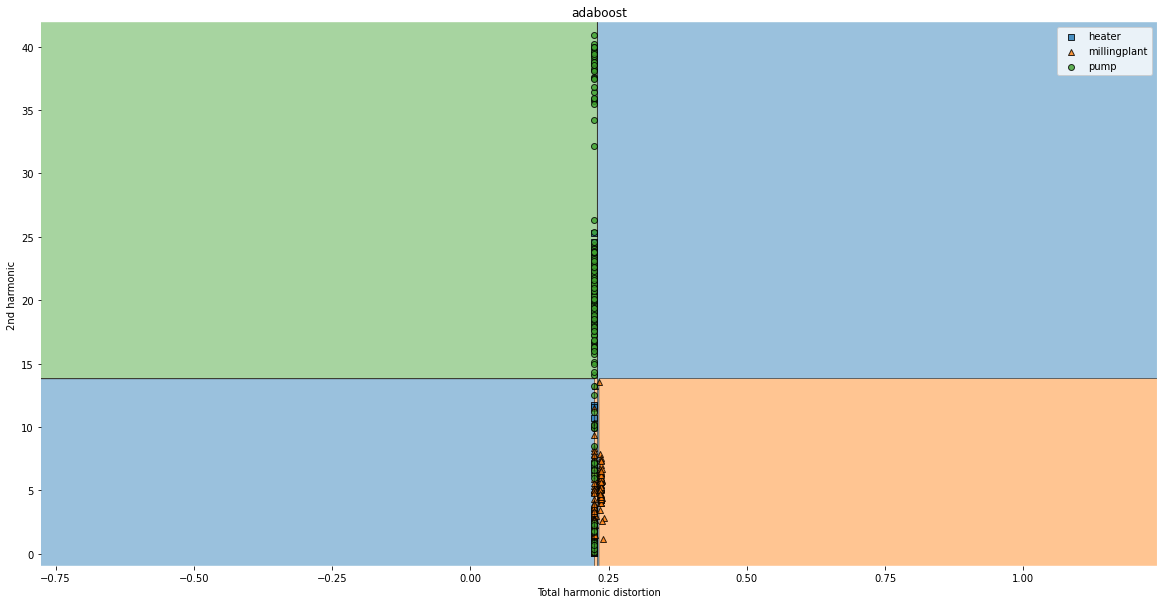

0.9332598273459503 0.9331782691139627


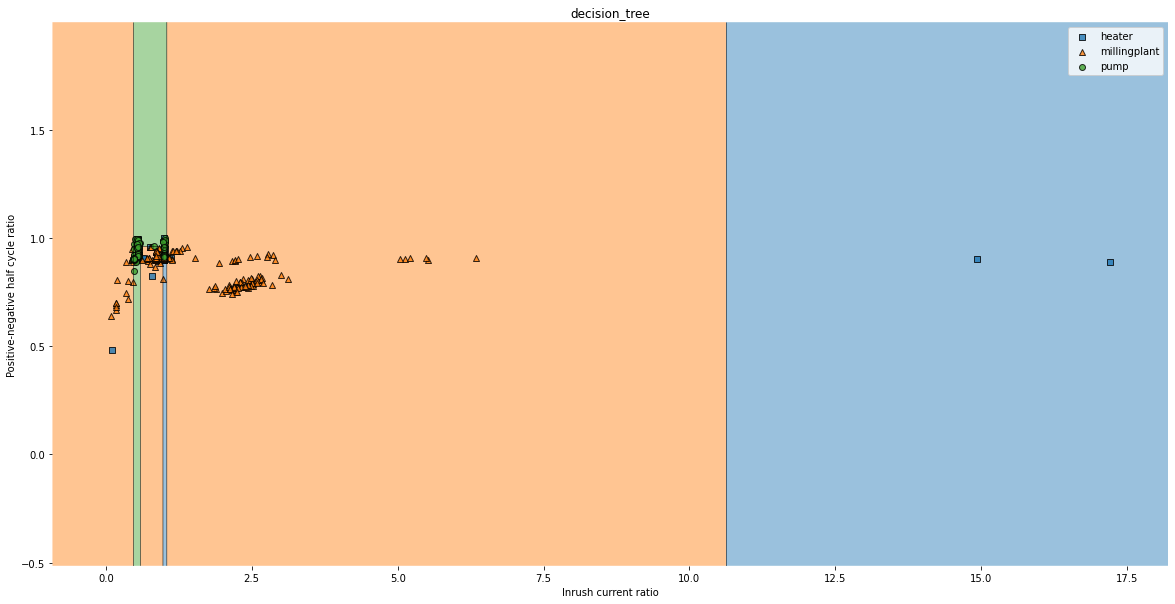

0.9231652942789038 0.8209588596578004


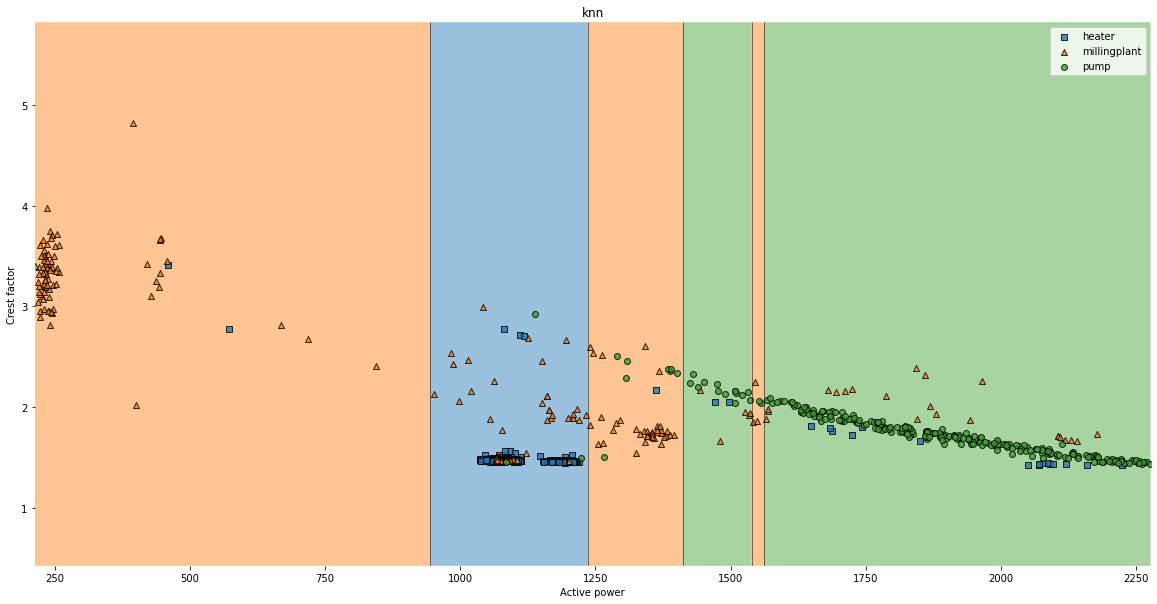

0.8387167522844867 0.8387167522844867


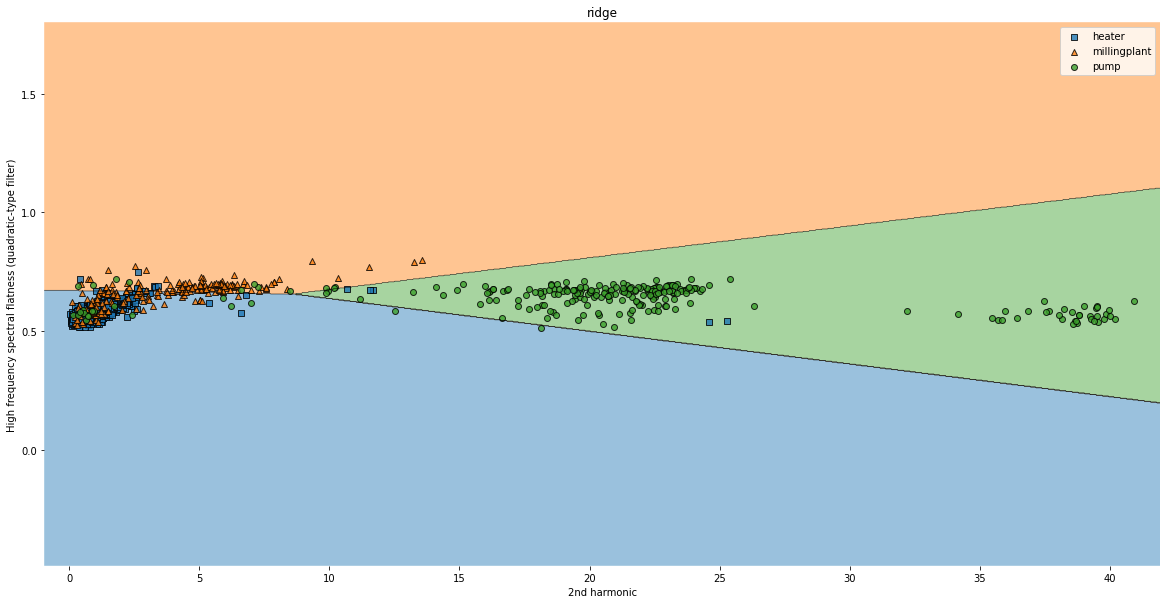

0.9312108028071602 0.7922181538132826


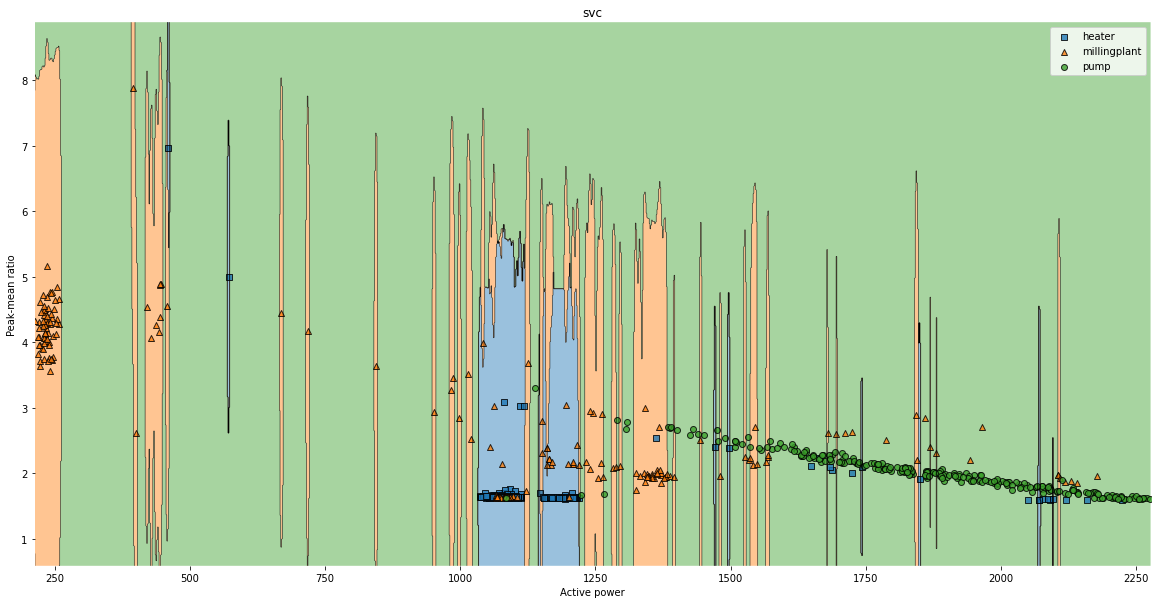

In [23]:
from mlxtend.plotting import plot_decision_regions
themes.theme_reset()

# Mlxtend can only handle numerical labels, so convert
unique_labels = list(np.unique(y))
f = np.vectorize(lambda label: unique_labels.index(label))
y_int = f(y)

for i, row in df.iterrows():
    # Fit estimator to optimal two-dimensional feature combination
    used_features = np.hstack(
        tuple(features[feature] for feature in row.feature_combination)
    )
    evaluation = feature_selection.get_evaluation(row.model)
    score, estimator = evaluation(used_features, y_int)

    # Create figure and fill with decision regions plot
    print(row.score, score)
    fig, ax = plt.subplots(figsize=(20, 10))
    plot_decision_regions(used_features, y_int, clf=estimator, legend=0, ax=ax)
    
    # Add title, labels and fix legend (convert numerical labels to actual ones)
    plt.title(row.model)
    plt.xlabel(row.feature_combination[0])
    plt.ylabel(row.feature_combination[1])
    for i, line in enumerate(ax.get_legend_handles_labels()[0]):
        line.set_label(unique_labels[i])
    ax.legend()

    # Save figure and show it
    fig.savefig(
        f'../thesis/figures/decision_regions/{row.model}_decision_region.pdf',
        bbox_inches='tight'
    )
    plt.show()

themes.theme_minimal()

<ipython-input-74-c7006a316647>:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(
/home/felix/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


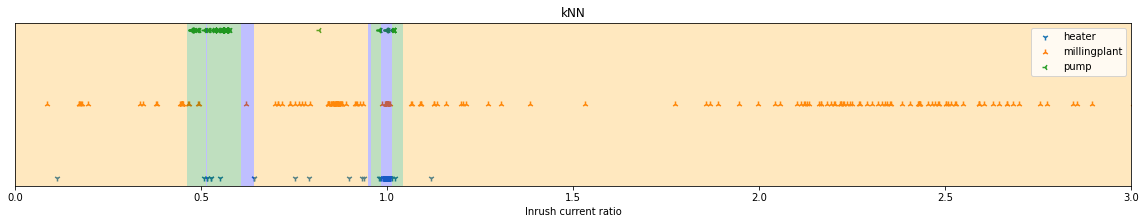

<ipython-input-74-c7006a316647>:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(
/home/felix/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


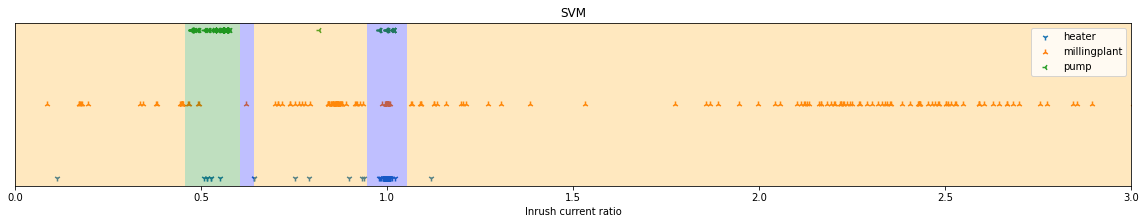

<ipython-input-74-c7006a316647>:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(
/home/felix/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


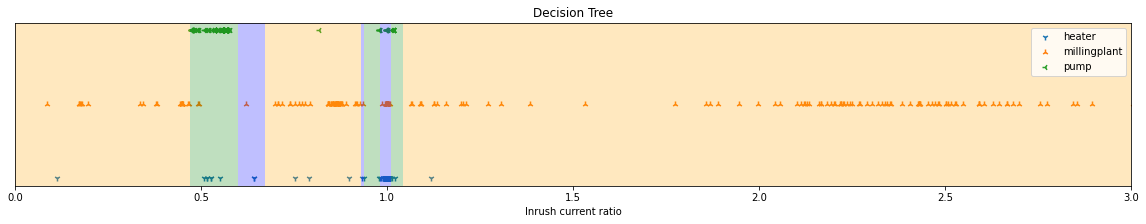

In [24]:
themes.theme_matplotlib_default()

unique_labels = list(np.unique(y))
f = np.vectorize(lambda label: unique_labels.index(label))
y_int = f(y)

def plot_decision_regions(estimator, name):
    fig, ax = plt.subplots(figsize=(20, 3))
    cmap = lambda x: 'b' if x==0 else 'orange' if x==1 else 'green'
    x = np.arange(np.min(X)-1, np.max(X)+1, 0.001)
    preds = estimator.predict(x.reshape(-1, 1))

    # Horribly inefficient but works ;)
    for i in range(x.shape[0]-1):
        plt.axvspan(x[i], x[i+1], facecolor=cmap(preds[i]), alpha=0.25)

    for label in np.unique(y):
        plt.scatter(X[y == label].reshape(-1,), y_int[y == label],
                    marker=str(unique_labels.index(label)+1), label=label)

    plt.legend()
    plt.title(name)
    plt.xlim(0, 3)
    plt.xlabel("Inrush current ratio")
    plt.yticks(ticks=())

    fig.savefig(
        f'../thesis/figures/decision_regions/icr_{name}_decision_region.pdf',
        bbox_inches='tight'
    )
    plt.show()

X = features['Inrush current ratio']
evaluation = feature_selection.get_evaluation('knn')
score, estimator = evaluation(X, y_int)
plot_decision_regions(estimator, "kNN")

evaluation = feature_selection.get_evaluation('svc')
score, estimator = evaluation(X, y_int)
plot_decision_regions(estimator, "SVM")

evaluation = feature_selection.get_evaluation('decision_tree')
score, estimator = evaluation(X, y_int)
plot_decision_regions(estimator, "Decision Tree")

themes.theme_minimal()

### Confusion matrices and balanced accuracy

In [25]:
eval_df = pd.DataFrame(
    columns=['type', 'model', 'feature_combination', 'dimension', 'score']
)

with open('notebooks/single_features.pkl', 'rb') as f:
    df = pickle.load(f)
classifiers = ['knn', 'svc', 'ridge', 'decision_tree', 'adaboost']
for classifier in classifiers:
    best_feature = df[classifier].idxmax()
    eval_df.loc[len(eval_df)] = \
        ('best_single', classifier, (best_feature,),
         df.loc[best_feature].dimension, df.loc[best_feature][classifier])
eval_df['dimension'] = eval_df['dimension'].astype(np.int)
eval_df.drop('type', axis=1)

,model,feature_combination,dimension,score
0,knn,"(Inrush current ratio,)",1,0.912744
1,svc,"(Wavelet transform energy over time (current),)",5,0.929669
2,ridge,"(Harmonics (first 20),)",20,0.894993
3,decision_tree,"(Inrush current ratio,)",1,0.921396
4,adaboost,"(Harmonics energy distribution,)",20,0.908452


In [26]:
with open('notebooks/single_features.pkl', 'rb') as f:
    df = pickle.load(f)
df = df[df.dimension == 1]
classifiers = ['knn', 'svc', 'ridge', 'decision_tree', 'adaboost']
for classifier in classifiers:
    best_feature = df[classifier].idxmax()
    eval_df.loc[len(eval_df)] = \
        ('best_one_dim', classifier, (best_feature,),
         df.loc[best_feature].dimension, df.loc[best_feature][classifier])
eval_df['dimension'] = eval_df['dimension'].astype(np.int)
eval_df[eval_df.type == 'best_one_dim'].drop('type', axis=1)

,model,feature_combination,dimension,score
5,knn,"(Inrush current ratio,)",1,0.912744
6,svc,"(Inrush current ratio,)",1,0.918628
7,ridge,"(2nd harmonic,)",1,0.607174
8,decision_tree,"(Inrush current ratio,)",1,0.921396
9,adaboost,"(Total harmonic distortion,)",1,0.874469


In [27]:
with open('notebooks/two_combs.pkl', 'rb') as f:
    df = pickle.load(f)
df = df.loc[df.dimension == 2]
df = df.loc[df.groupby('model').apply(lambda x: x.score.idxmax())]
df['type'] = 'best_two_dim_comb'
eval_df = pd.concat((eval_df, df))
df.drop('type', axis=1)

,model,feature_combination,dimension,score
6774,adaboost,"(Total harmonic distortion, 2nd harmonic)",2,0.905937
5599,decision_tree,"(Inrush current ratio, Positive-negative half ...",2,0.933260
10,knn,"(Active power, Crest factor)",2,0.923165
4376,ridge,"(2nd harmonic, High frequency spectral flatnes...",2,0.838717
1564,svc,"(Active power, Peak-mean ratio)",2,0.931211


In [28]:
with open('notebooks/two_combs.pkl', 'rb') as f:
    df = pickle.load(f)
df = df.loc[df.groupby('model').apply(lambda x: x.score.idxmax())]
df['type'] = 'best_two_comb'
eval_df = pd.concat((eval_df, df))
df.drop('type', axis=1)

,model,feature_combination,dimension,score
6484,adaboost,"(Harmonics energy distribution, Admittance (me...",21,0.918578
5599,decision_tree,"(Inrush current ratio, Positive-negative half ...",2,0.933260
1038,knn,"(Positive-negative half cycle ratio, Wavelet t...",6,0.924557
3337,ridge,"(VI Trajectory, Wavelet transform (all levels)...",52,0.923115
1748,svc,"(Phase shift, Wavelet transform energy over ti...",6,0.935562


In [29]:
with open('notebooks/stepwise_regression_any.pkl', 'rb') as f:
    df = pickle.load(f)
df['type'] = 'best_any_comb'
df['feature_combination'] = df['features']
df['model'] = df.index
df = df[['type', 'model', 'feature_combination', 'dimension', 'score']]
eval_df = pd.concat((eval_df, df))
df.drop('type', axis=1)

,model,feature_combination,dimension,score
knn,knn,"[Inrush current ratio, Odd even harmonics rati...",3,0.921748
svc,svc,"[Wavelet transform energy over time (current),...",10,0.94738
ridge,ridge,"[Harmonics (first 20), Harmonics energy distri...",102,0.935085
decision_tree,decision_tree,"[Inrush current ratio, Positive-negative half ...",3,0.934616
adaboost,adaboost,"[Harmonics energy distribution, Resistance (me...",22,0.925007


In [30]:
eval_df

,type,model,feature_combination,dimension,score
0,best_single,knn,"(Inrush current ratio,)",1,0.912744
1,best_single,svc,"(Wavelet transform energy over time (current),)",5,0.929669
2,best_single,ridge,"(Harmonics (first 20),)",20,0.894993
3,best_single,decision_tree,"(Inrush current ratio,)",1,0.921396
4,best_single,adaboost,"(Harmonics energy distribution,)",20,0.908452
5,best_one_dim,knn,"(Inrush current ratio,)",1,0.912744
6,best_one_dim,svc,"(Inrush current ratio,)",1,0.918628
7,best_one_dim,ridge,"(2nd harmonic,)",1,0.607174
8,best_one_dim,decision_tree,"(Inrush current ratio,)",1,0.921396
9,best_one_dim,adaboost,"(Total harmonic distortion,)",1,0.874469



 best_single knn ('Inrush current ratio',) 0.904


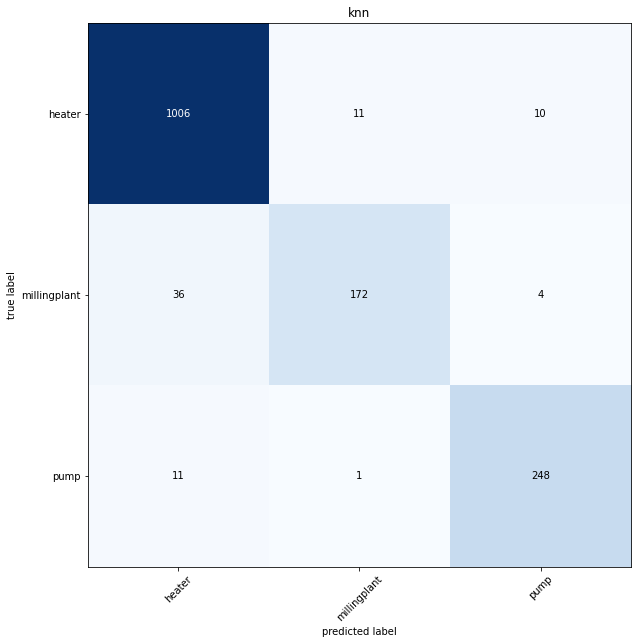


 best_single svc ('Wavelet transform energy over time (current)',) 0.915


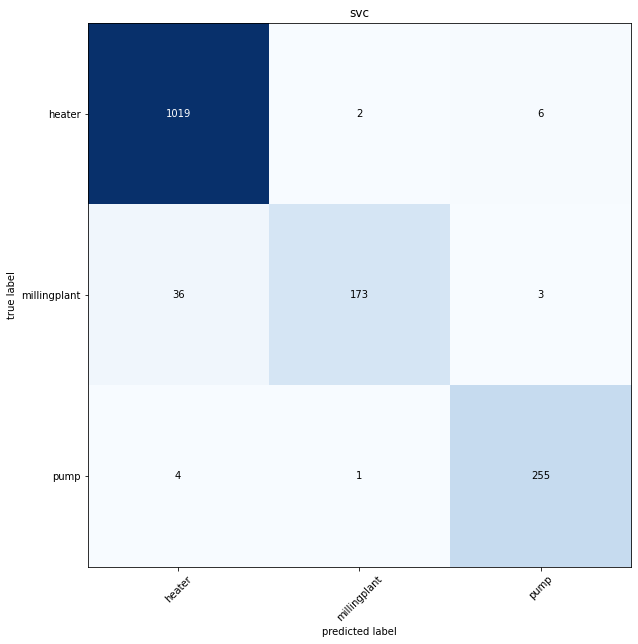


 best_single ridge ('Harmonics (first 20)',) 0.887


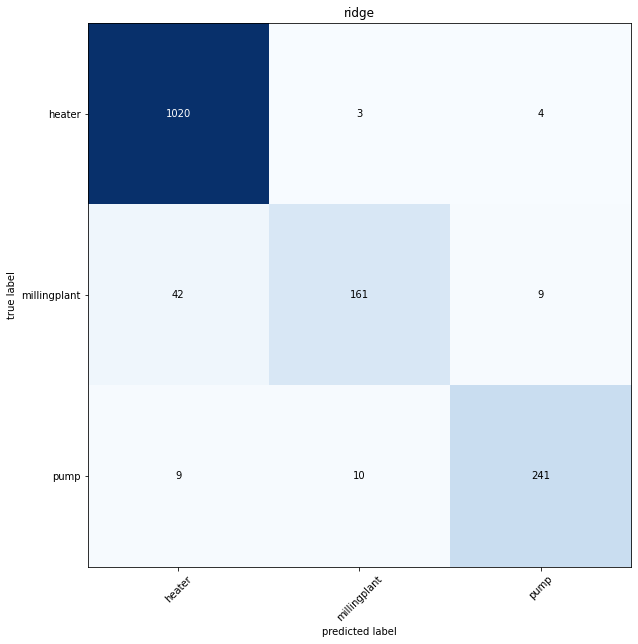


 best_single decision_tree ('Inrush current ratio',) 0.908


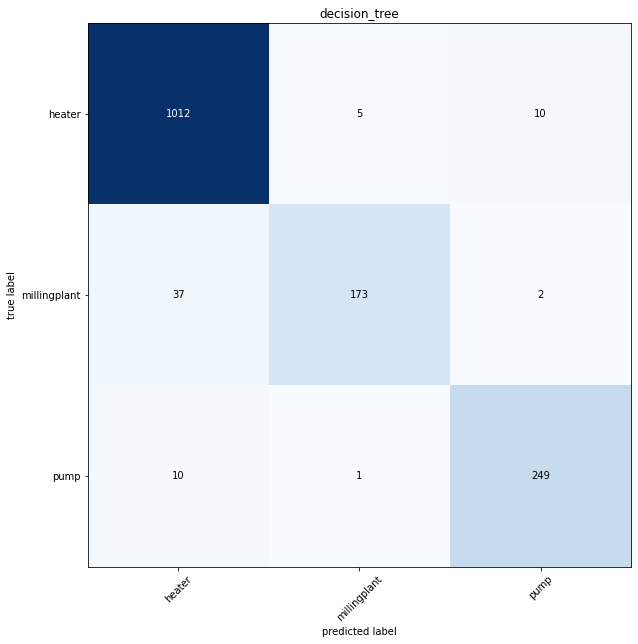


 best_single adaboost ('Harmonics energy distribution',) 0.91


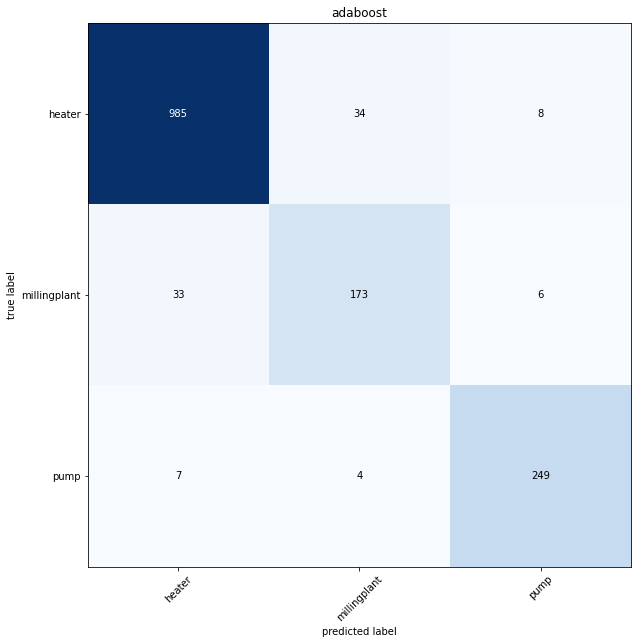


 best_one_dim knn ('Inrush current ratio',) 0.904


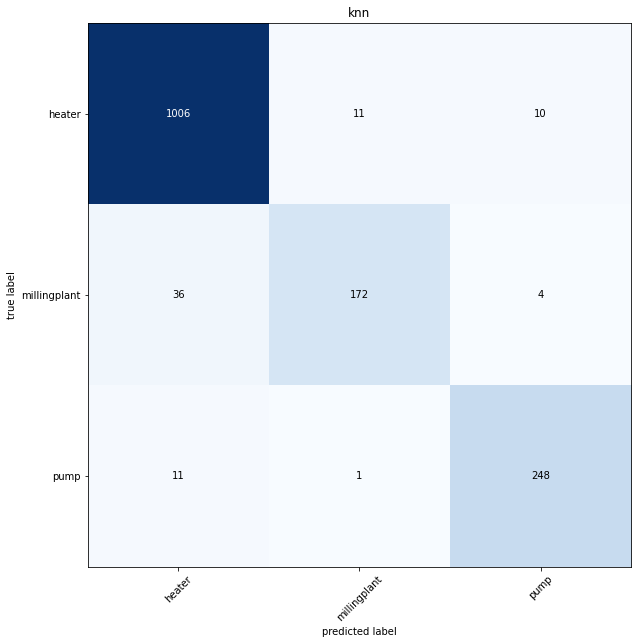


 best_one_dim svc ('Inrush current ratio',) 0.899


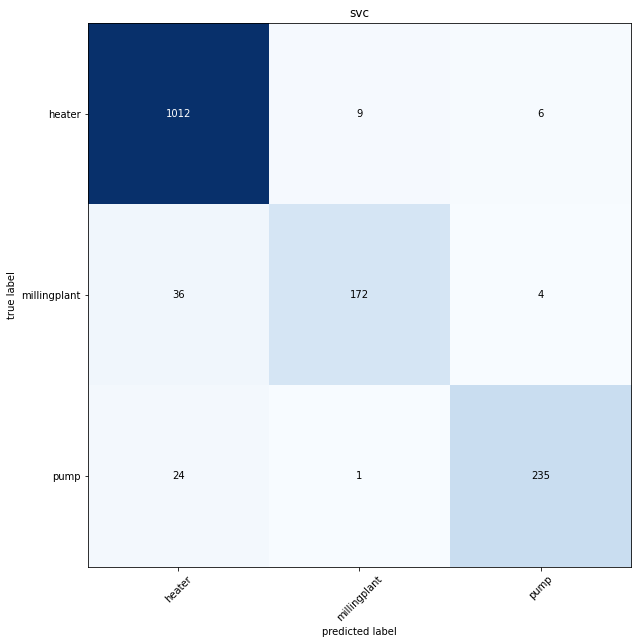


 best_one_dim ridge ('2nd harmonic',) 0.628


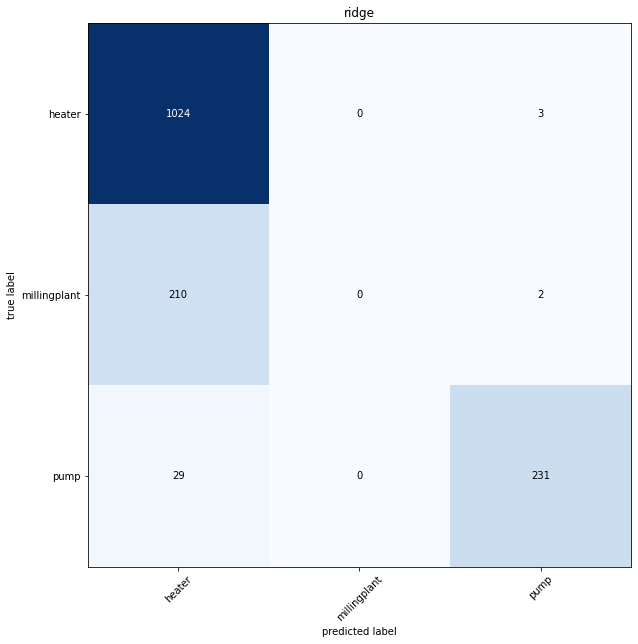


 best_one_dim decision_tree ('Inrush current ratio',) 0.908


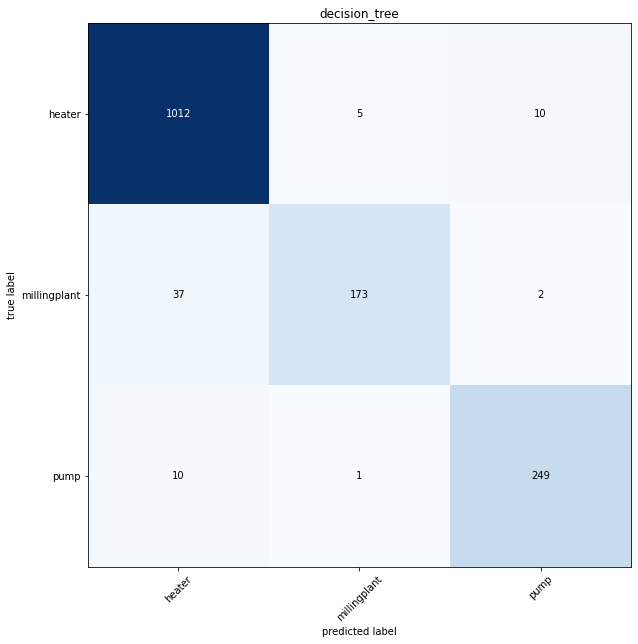


 best_one_dim adaboost ('Total harmonic distortion',) 0.868


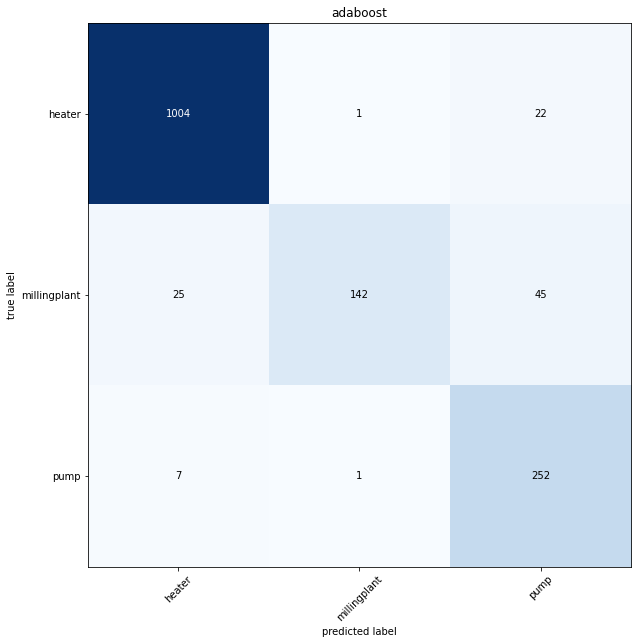


 best_two_dim_comb adaboost ('Total harmonic distortion', '2nd harmonic') 0.908


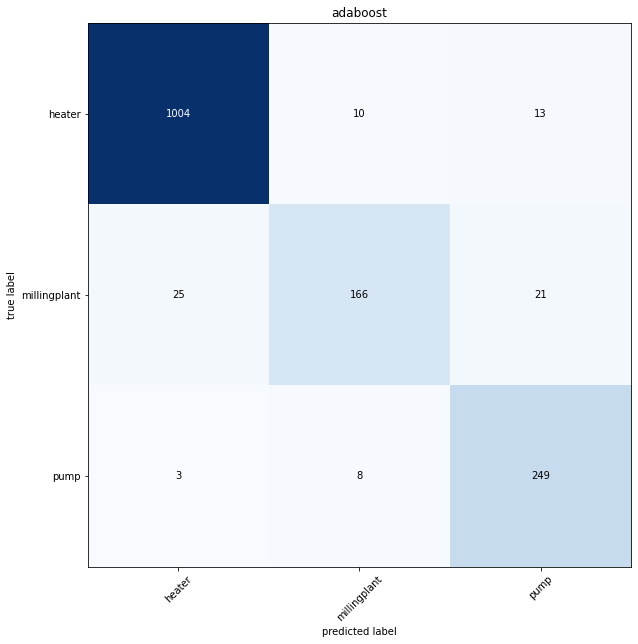


 best_two_dim_comb decision_tree ('Inrush current ratio', 'Positive-negative half cycle ratio') 0.922


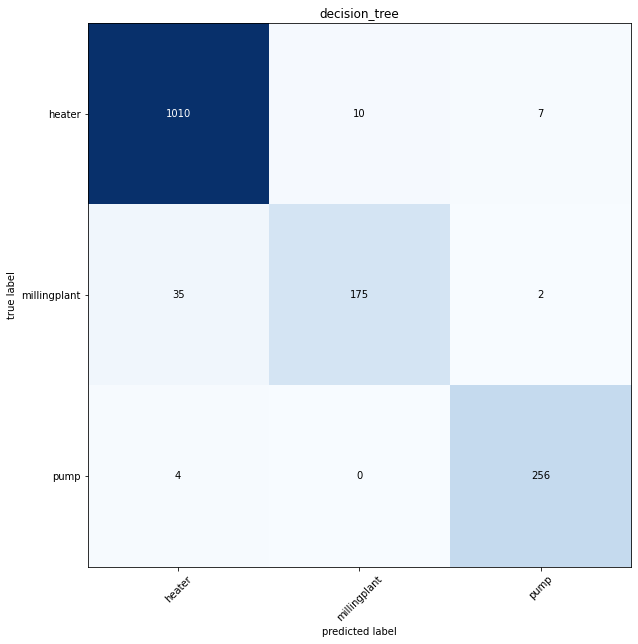


 best_two_dim_comb knn ('Active power', 'Crest factor') 0.913


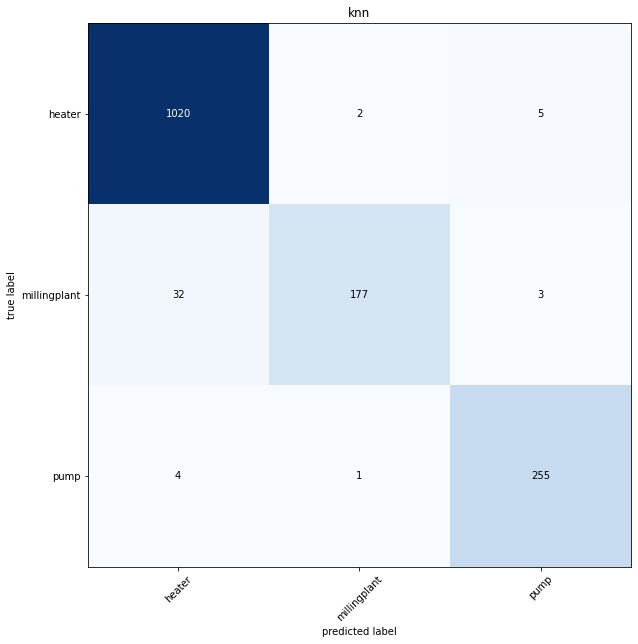


 best_two_dim_comb ridge ('2nd harmonic', 'High frequency spectral flatness (quadratic-type filter)') 0.803


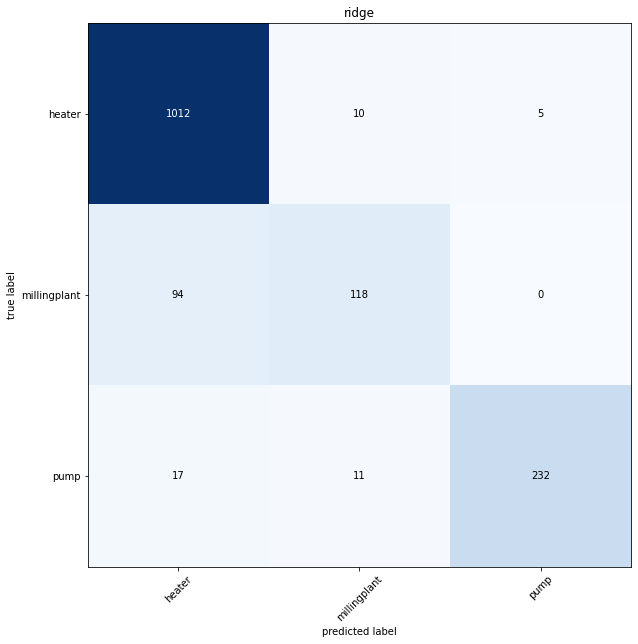


 best_two_dim_comb svc ('Active power', 'Peak-mean ratio') 0.931


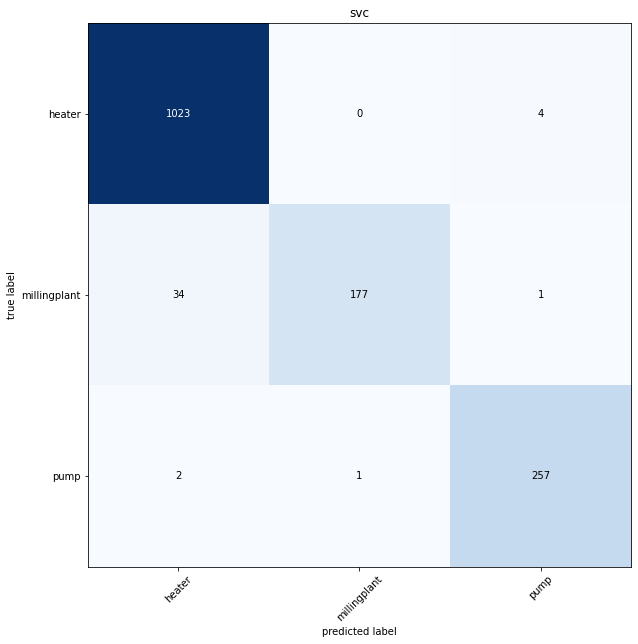


 best_two_comb adaboost ('Harmonics energy distribution', 'Admittance (median)') 0.936


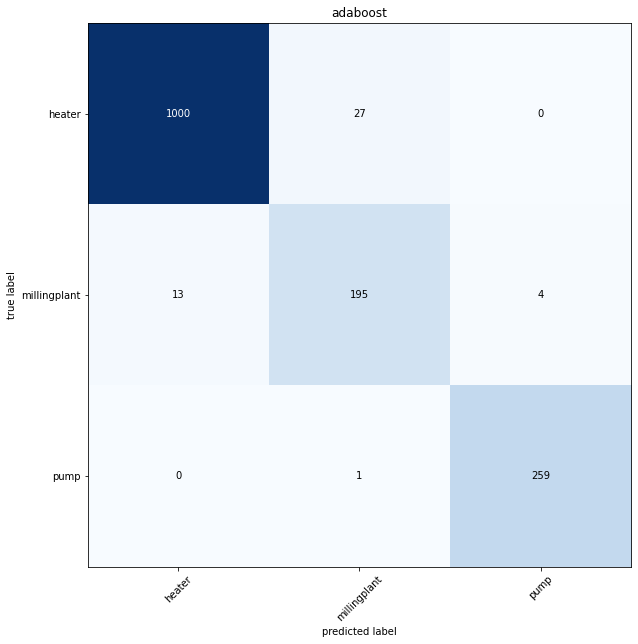


 best_two_comb decision_tree ('Inrush current ratio', 'Positive-negative half cycle ratio') 0.922


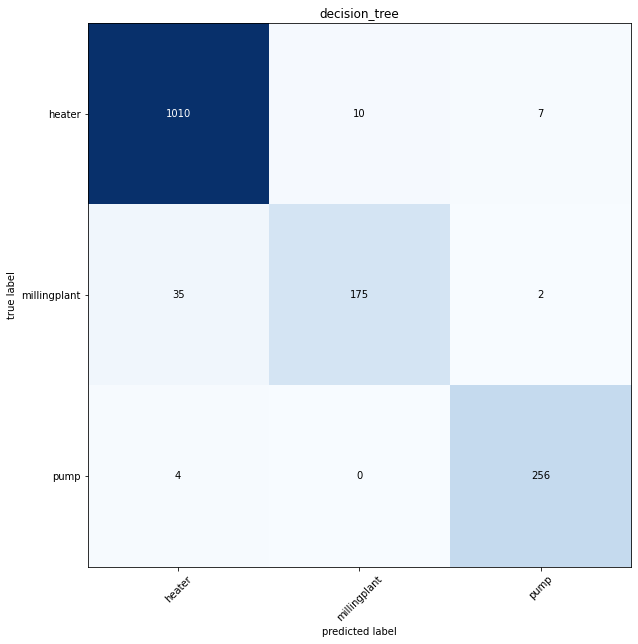


 best_two_comb knn ('Positive-negative half cycle ratio', 'Wavelet transform energy over time (current)') 0.914


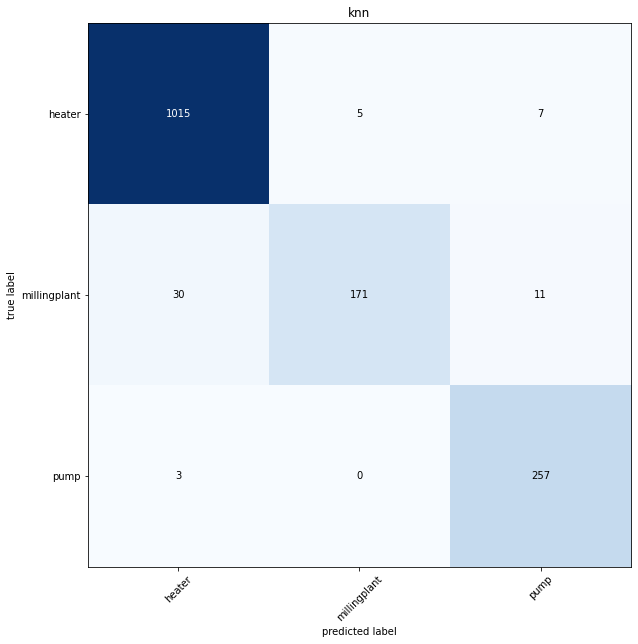


 best_two_comb ridge ('VI Trajectory', 'Wavelet transform (all levels) energy (current)') 0.925


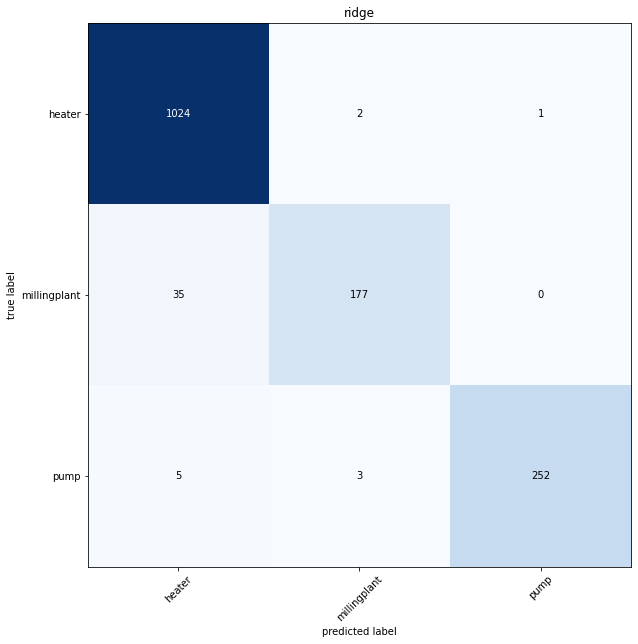


 best_two_comb svc ('Phase shift', 'Wavelet transform energy over time (current)') 0.921


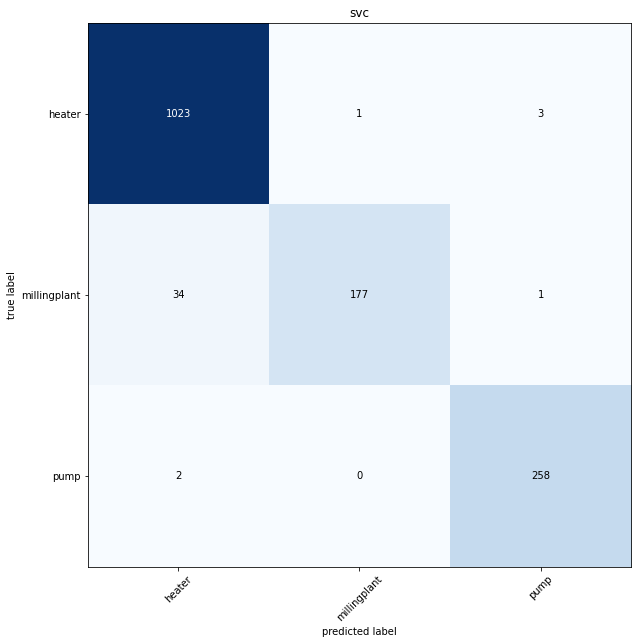


 best_any_comb knn ['Inrush current ratio', 'Odd even harmonics ratio', 'Wavelet transform dominant scale (voltage)'] 0.904


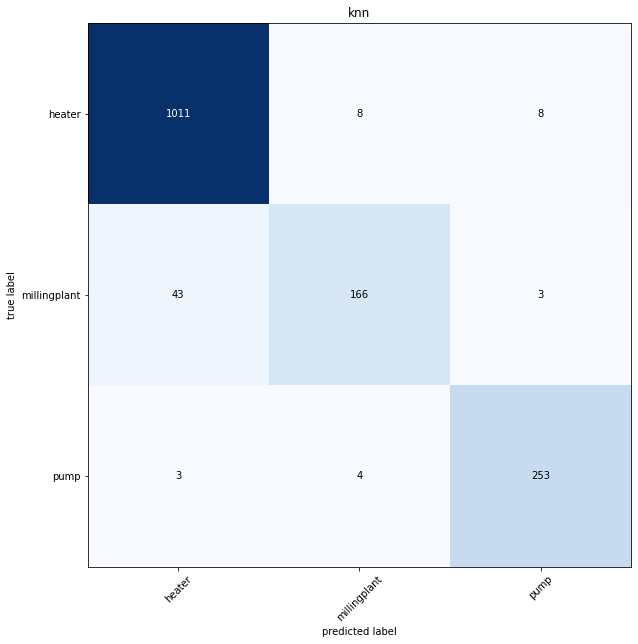


 best_any_comb svc ['Wavelet transform energy over time (current)', 'Phase shift', 'Form factor', 'Mean variance ratio', 'Crest factor', '2nd harmonic'] 0.935


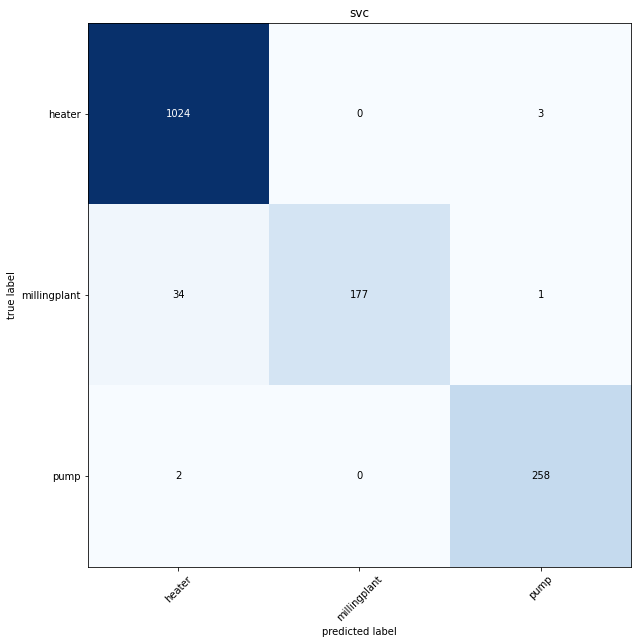


 best_any_comb ridge ['Harmonics (first 20)', 'Harmonics energy distribution', 'Current RMS', 'VI Trajectory', 'Wavelet transform (all levels) energy (current)', 'Total harmonic distortion', 'Reactive power', 'Max inrush ratio', 'Wavelet transform (1st level) energy (voltage)', 'Apparent power'] 0.944


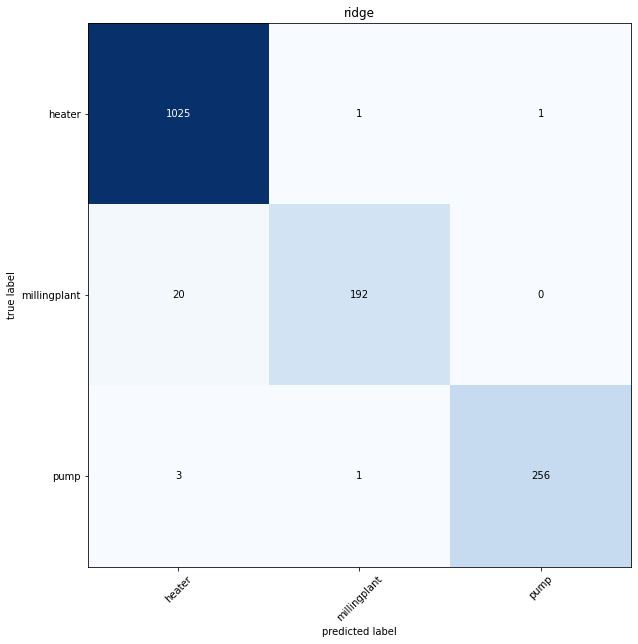


 best_any_comb decision_tree ['Inrush current ratio', 'Positive-negative half cycle ratio', 'Waveform distortion'] 0.924


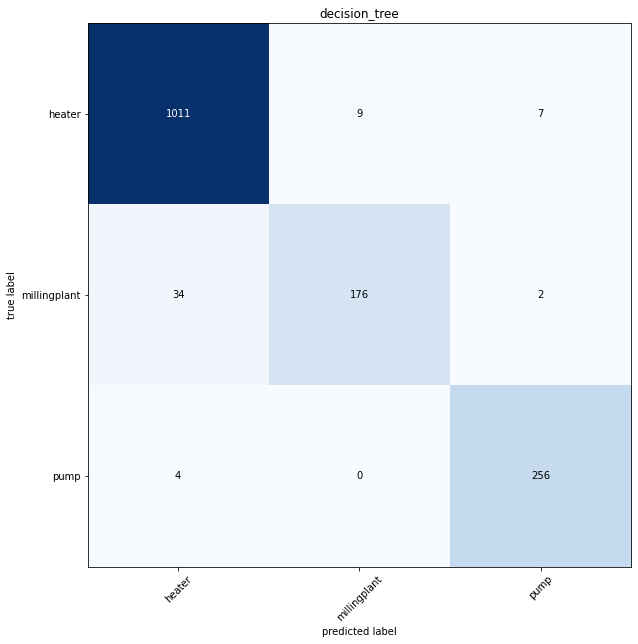


 best_any_comb adaboost ['Harmonics energy distribution', 'Resistance (median)', '(High frequency) Spectral mean (no high pass filter)'] 0.928


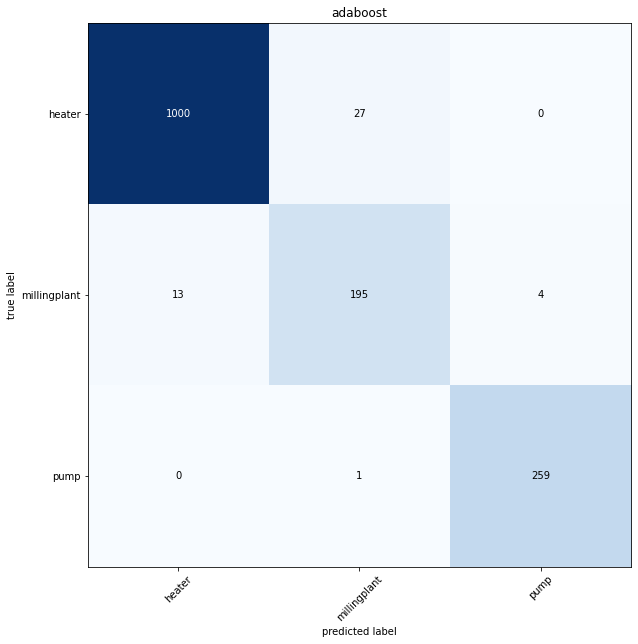

In [31]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
themes.theme_reset()

for i, row in eval_df.iterrows():
    # Fit estimator to selected feature combination
    used_features = np.hstack(
        tuple(n_features[feature] for feature in row.feature_combination)
    )
    evaluation = feature_selection.get_evaluation(row.model)
    score, estimator = evaluation(used_features, y)
    balanced_accuracy = round(np.mean(cross_val_score(
        estimator, used_features, y, scoring='balanced_accuracy', n_jobs=-1
    )), 3)
    eval_df.loc[i, 'balanced_accuracy'] = balanced_accuracy
    print('\n', row.type, row.model, row.feature_combination, balanced_accuracy)

    # Create the confusion matrix
    fig, ax = plt.subplots(figsize=(20, 10))
    matrix = confusion_matrix(y, estimator.predict(used_features))
    plot_confusion_matrix(matrix, axis=ax, class_names=np.unique(y))
    plt.title(row.model)
    
    # Save figure and show it
    fig.savefig(
        f'../thesis/figures/confusion_matrix/{row.type}_{row.model}_confusion_matrix.pdf',
        bbox_inches='tight'
    )
    plt.show()

themes.theme_minimal()

In [32]:
eval_df[['type', 'model', 'balanced_accuracy']]

,type,model,balanced_accuracy
0,best_single,knn,0.904
1,best_single,svc,0.915
2,best_single,ridge,0.887
3,best_single,decision_tree,0.908
4,best_single,adaboost,0.910
5,best_one_dim,knn,0.904
6,best_one_dim,svc,0.899
7,best_one_dim,ridge,0.628
8,best_one_dim,decision_tree,0.908
9,best_one_dim,adaboost,0.868


### Decision tree

In [33]:
import graphviz
from sklearn import tree


def get_feature_names(all_features, selected_features):
    feature_names = []

    for feature in selected_features:
        if all_features[feature].shape[1] > 1:
            for i in range(1, all_features[feature].shape[1]+1):
                feature_names.append(f"{feature} [{i}]")
        else:
            feature_names.append(feature)

    return feature_names


def cleanup_dot_data(dot_data):
    lines = []
    for line in dot_data.splitlines():
        # Only nodes are of interest
        if "[label=" in line:
            start = line.index('"')+1
            end = line[start:].index('"')
            parts = line[start:(start+end)].split('\\n')
            # Inner nodes: remove class and color
            if 'label="gini' not in line:
                parts = list(filter(lambda x: 'class' not in x, parts))
                line = line[:start] + '\\n'.join(parts) + '", fillcolor="#ffffff"] ;'
            # Leaf nodes: Leave alone
            else:
                line = line[:start] + '\\n'.join(parts) + line[start+end:]
            # One-line samples and values
            line = line.replace('\\nvalue', ', values')
        lines.append(line)
    return '\n'.join(lines)


def get_tree_rendering(best):
    feature_names = get_feature_names(n_features, best.feature_combination)
    dot_data = tree.export_graphviz(best.estimator,
                                    feature_names=feature_names, class_names=sorted(np.unique(y)),
                                    filled=True, rounded=True)
    return graphviz.Source(cleanup_dot_data(dot_data))

In [34]:
with open('notebooks/two_combs.pkl', 'rb') as f:
    df = pickle.load(f)
df = df.loc[df.groupby('model').apply(lambda x: x.score.idxmax())]
df = df.loc[df.model == 'decision_tree']
df

,model,feature_combination,dimension,score
5599,decision_tree,"(Inrush current ratio, Positive-negative half ...",2,0.93326


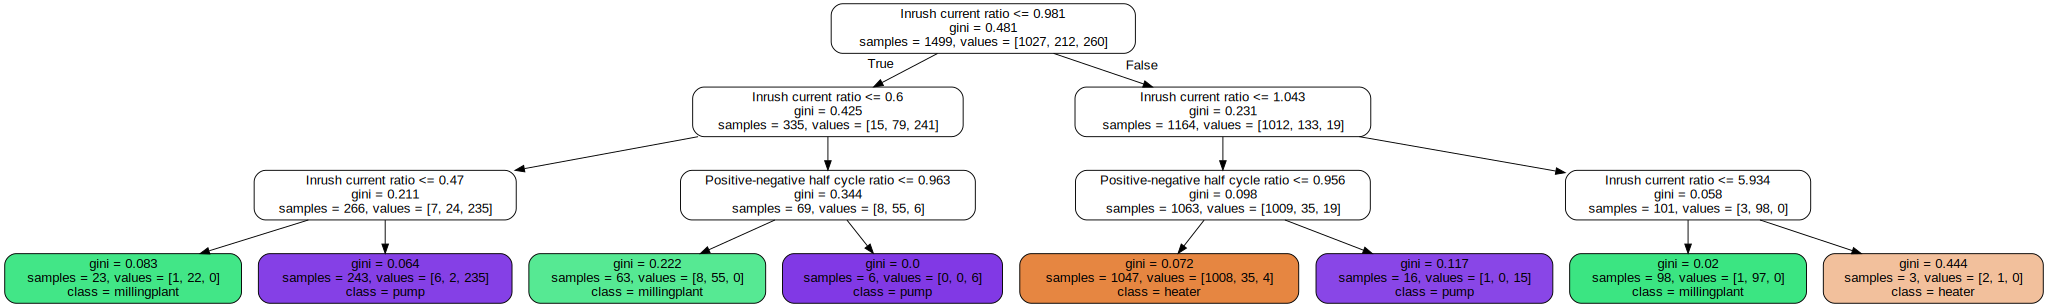

In [35]:
# Fit decision tree to optimal two-dimensional feature combination
best_decision_tree = copy.deepcopy(df.iloc[0])
used_features = np.hstack(
    tuple(features[feature] for feature in best_decision_tree.feature_combination)
)
evaluation = feature_selection.get_evaluation('decision_tree', custom_params={'min_samples_leaf': [3]})
score, best_decision_tree['estimator'] = evaluation(used_features, y)

graph = get_tree_rendering(best_decision_tree)
graph.render(filename='../thesis/figures/decision_tree', format='pdf', cleanup=True)
graph

## Single component identification

In [36]:
from functools import partial
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [37]:
def metric(estimator, X, y, component):
    preds_correct = (estimator.predict(X) == y)
    tp = preds_correct[y == component].sum()
    fn = preds_correct[y == component].shape[0] - tp
    tn = preds_correct[y != component].sum()
    fp = preds_correct[y != component].shape[0] - tn
    # print(tp, fn, tn, fp, tp+fn+tn+fp, tp+fn, fp+tn)
    if tp == 0:
        return 0.
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision == 0 or recall == 0:
        return 0.
    return 2 * (precision * recall) / (precision + recall)

classifier = DecisionTreeClassifier()
param_grid = {'max_depth': np.arange(1, 20, 2), 'min_samples_split': [5, 10, 50]}
cv = GridSearchCV(classifier, param_grid, n_jobs=-1)

components = ['heater', 'pump', 'millingplant']
df = pd.DataFrame(columns=components + ['overall'])

for feature in features:
    X = n_features[feature]

    overall, _ = feature_selection.get_evaluation('decision_tree')(X, y)
    df.loc[feature, 'overall'] = overall

    for component in components:
        y_prime = np.vectorize(lambda x: x if x == component else 'other')(y)
        cv.fit(X, y_prime)
        scoring = partial(metric, component=component)
        score = np.mean(cross_val_score(cv, X, y_prime, scoring=scoring))
        df.loc[feature, component] = score
for component in components:
    df[component] = df[component].astype(np.float)
df

,heater,pump,millingplant,overall
Active power,0.961262,0.872147,0.644257,0.844327
Reactive power,0.960289,0.904137,0.693925,0.849405
Apparent power,0.960766,0.896280,0.665443,0.857678
Phase shift,0.956931,0.822144,0.666499,0.835535
VI Trajectory,0.911706,0.939715,0.653905,0.791054
Harmonics (first 20),0.939855,0.916481,0.764732,0.903647
Harmonics energy distribution,0.949820,0.924277,0.777815,0.910068
Spectral flatness,0.941534,0.784210,0.658546,0.804053
Odd even harmonics ratio,0.946762,0.881400,0.625155,0.816163
Tristimulus,0.908989,0.925104,0.749464,0.841175


In [38]:
eval_df = pd.DataFrame(
    columns=['feature', 'score', 'overall']
)
for component in components:
    best_feature = df[component].idxmax()
    eval_df.loc[component] = (best_feature, df.loc[best_feature, component], df.loc[best_feature, 'overall'])
# print(df_to_latex_table(eval_df, remove_index=False))
eval_df

,feature,score,overall
heater,Current RMS,0.971795,0.921506
pump,Current RMS,0.945119,0.921506
millingplant,Inrush current ratio,0.863431,0.921396


In [39]:
eval_df = pd.DataFrame(
    columns=['feature', 'score', 'overall']
)
one_dim_features = list(filter(lambda x: features[x].shape[1] == 1, features))
for component in components:
    best_feature = df.loc[one_dim_features][component].idxmax()
    eval_df.loc[component] = (best_feature, df.loc[best_feature, component], df.loc[best_feature, 'overall'])
eval_df

,feature,score,overall
heater,Mean variance ratio,0.968288,0.867550
pump,Inrush current ratio,0.924424,0.921396
millingplant,Inrush current ratio,0.863431,0.921396


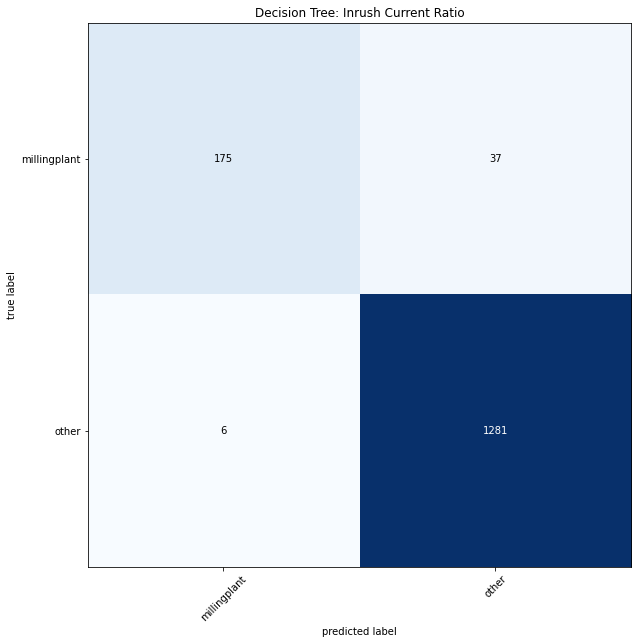

In [40]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
themes.theme_reset()

classifier = DecisionTreeClassifier()
param_grid = {'max_depth': np.arange(1, 20, 2), 'min_samples_split': [5, 10, 50]}
cv = GridSearchCV(classifier, param_grid, n_jobs=-1)
X = n_features["Inrush current ratio"]
y_prime = np.vectorize(lambda x: x if x == 'millingplant' else 'other')(y)
cv.fit(X, y_prime)


# Create figure and fill with decision regions plot
fig, ax = plt.subplots(figsize=(10, 10))
matrix = confusion_matrix(y_prime, cv.predict(X))
plot_confusion_matrix(matrix, axis=ax, class_names=np.unique(y_prime))
plt.title("Decision Tree: Inrush Current Ratio")
plt.show()

themes.theme_minimal()